In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Bidirectional
from keras import backend as K
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import os

generation_data = pd.read_csv('/content/gdrive/My Drive/capstone1/generation.csv')
generation_data.head()
weather_data = pd.read_csv('/content/gdrive/My Drive/capstone1/weather.csv')
weather_data.head()

datetime  temperature  precipitation  ...  humidity  sunlight  generation
0  2017/01/01 1:00          5.0            NaN  ...      93.0       NaN         NaN
1  2017/01/01 2:00          4.1            NaN  ...      93.0       NaN         NaN
2  2017/01/01 3:00          3.3            NaN  ...      94.0       NaN         NaN
3  2017/01/01 4:00          2.5            NaN  ...      95.0       NaN         NaN
4  2017/01/01 5:00          2.1            NaN  ...      97.0       NaN         NaN

[5 rows x 7 columns]

In [ ]:
def merge_data(g_data, w_data):
    temp_data = w_data
    for index in g_data.index:
        for hour in range(0, 24):
            temp_data.iloc[index*24 + hour, 14] = g_data.iloc[index, hour+2]
    return temp_data.fillna(0)

In [ ]:
transformed_data = merge_data(generation_data, weather_data)

In [3]:
# transformed_data.to_csv('/content/gdrive/My Drive/capstone1/total_data.csv', mode='w')
transformed_data = pd.read_csv('/content/gdrive/My Drive/capstone1/total_data.csv')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8aadc7e80>,
      dtype=object)

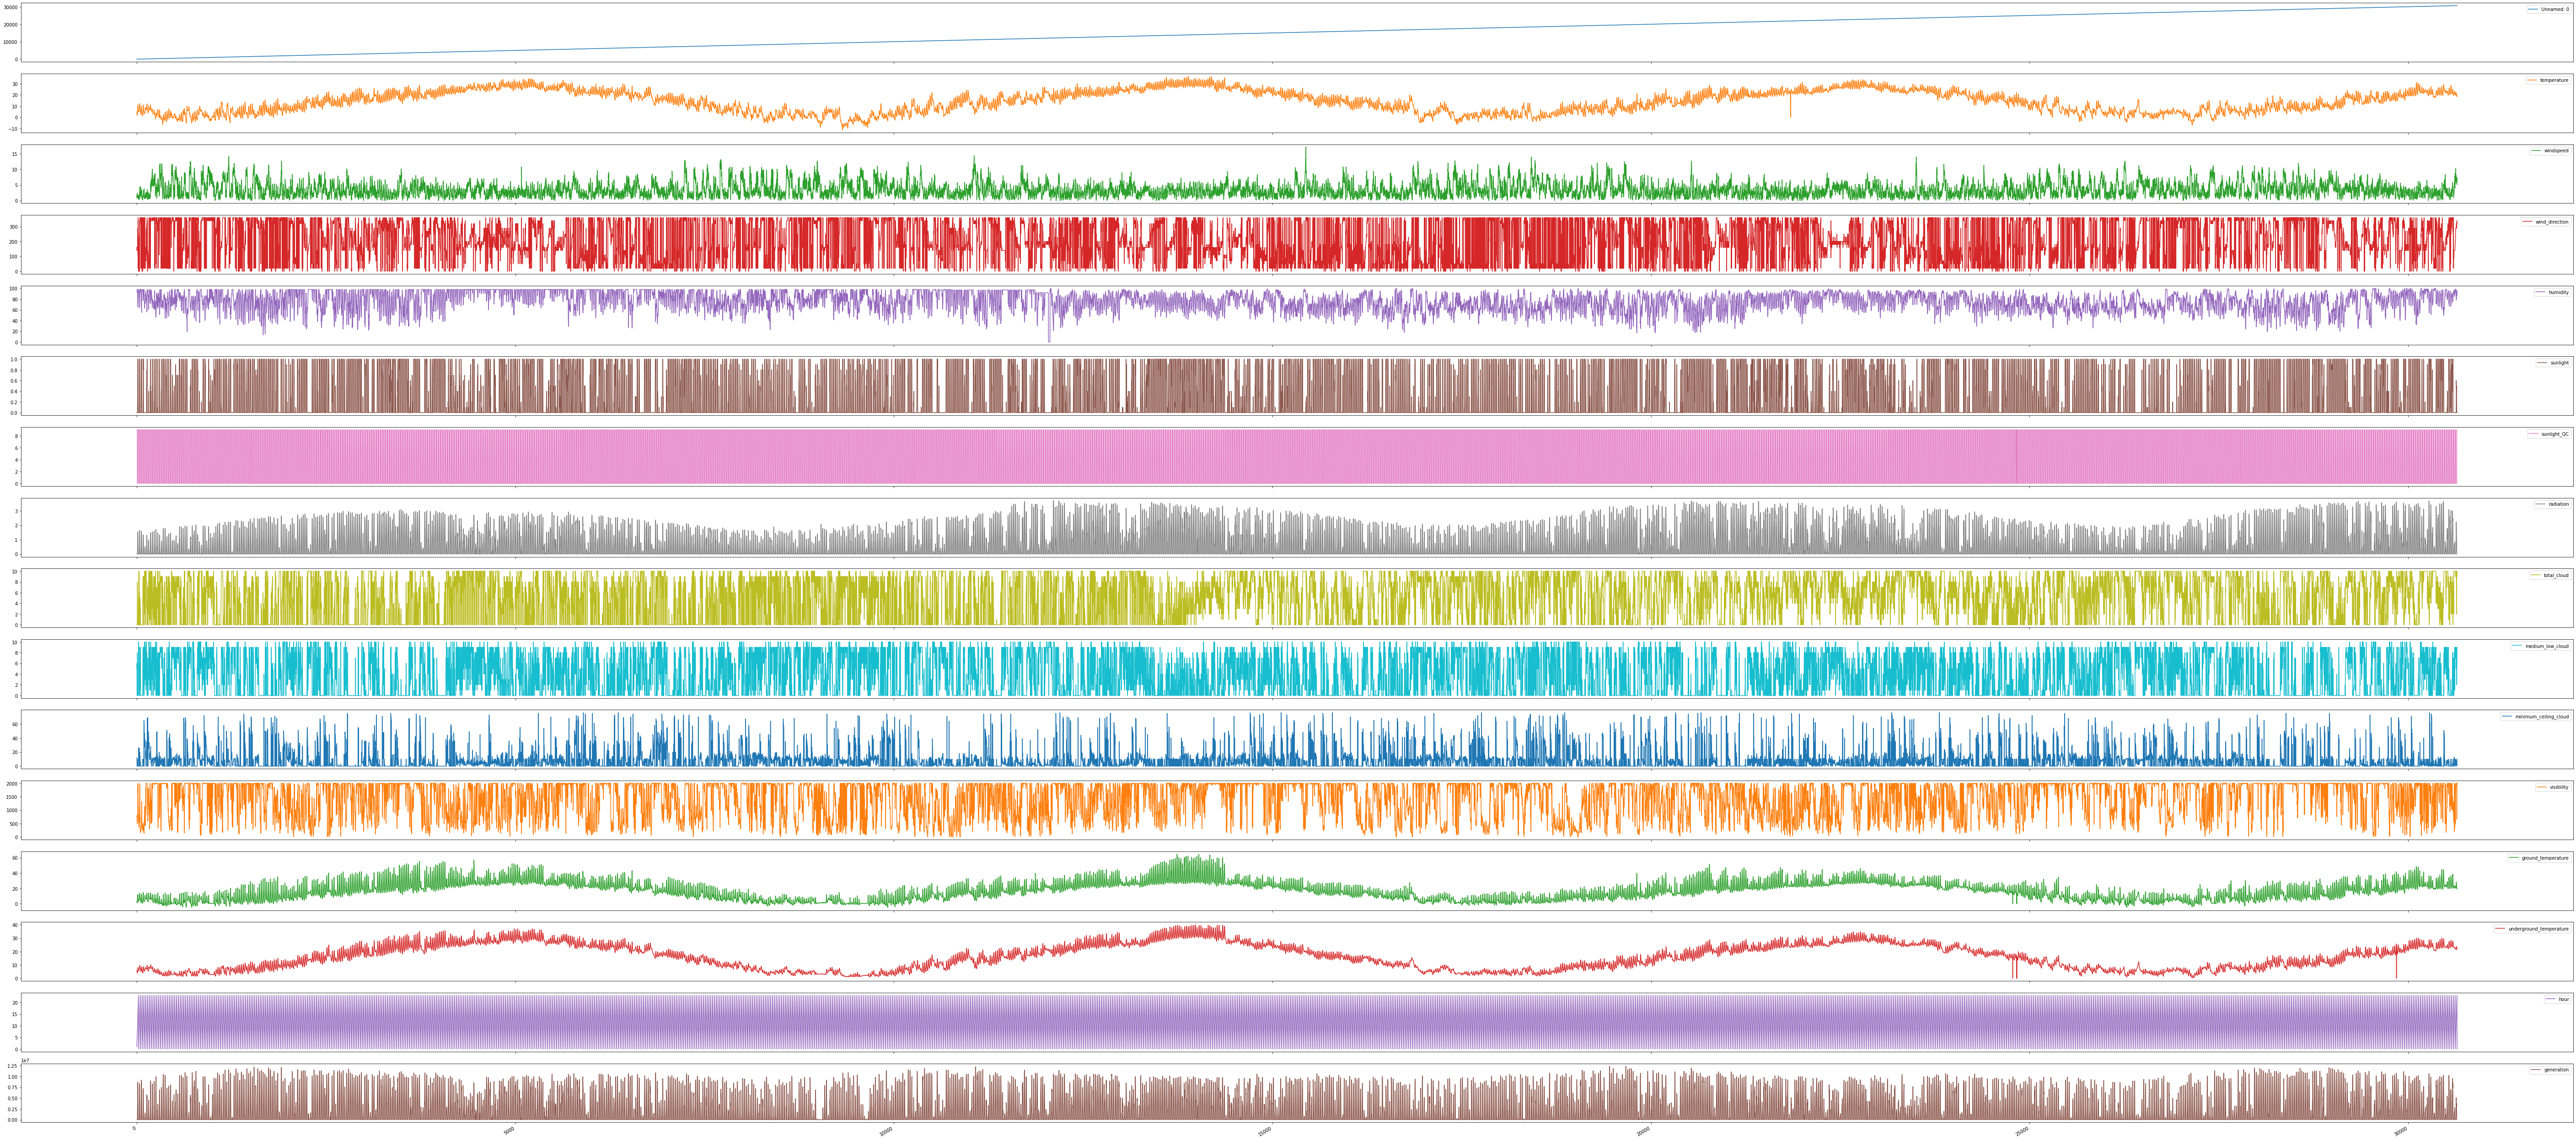

In [4]:
transformed_data.plot(subplots=True, figsize=(100,50))

In [5]:
features = ['temperature', 'windspeed', 'wind_direction', 'humidity', 'sunlight', 
         'sunlight_QC', 'radiation', 'total_cloud', 'medium_low_cloud', 
         'minimum_ceiling_cloud', 'visibility', 'ground_temperature', 
         'underground_temperature', 'hour','generation']
features = transformed_data[features]
features.index = transformed_data['datetime']
features.head()

temperature  windspeed  ...  hour  generation
datetime                                 ...                  
2017-01-01 1:00          5.0        1.8  ...   1.0         0.0
2017-01-01 2:00          4.1        0.8  ...   2.0         0.0
2017-01-01 3:00          3.3        1.5  ...   3.0         0.0
2017-01-01 4:00          2.5        1.8  ...   4.0         0.0
2017-01-01 5:00          2.1        1.8  ...   5.0         0.0

[5 rows x 15 columns]

In [6]:
train_size = int(len(transformed_data) * 0.7)
tf.random.set_seed(30)

dataset = features.values
data_mean = dataset[:train_size].mean(axis=0)
data_std = dataset[:train_size].std(axis=0)
dataset = (dataset - data_mean)/data_std

In [7]:
def multivariate_data(dataset, target, start_index, end_index, history_size, 
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])
    return np.array(data, dtype=np.float), np.array(labels, dtype=np.float)

In [8]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['history', 'true future', 'model prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-step')
    return plt

In [9]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12,6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, np.array(history[:, 14]), label='history')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'b', label='true future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'r', label='predicted future')
    plt.legend(loc='upper left')
    plt.show()

In [10]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='train_loss')
    plt.plot(epochs, val_loss, 'r', label='val_loss')
    plt.title(title)
    plt.legend()
    plt.show

In [11]:
past_history = 720
future_target = 24
STEP = 1

x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 14], 0, 
                                                   train_size, past_history, 
                                                   future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 14], 
                                               train_size, None, past_history, 
                                               future_target, STEP)

In [12]:
print('single window of past history')
print(x_train_multi.shape)

single window of past history
(20733, 720, 15)


In [13]:
batch_size = 64
buffer_size = 10000

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(buffer_size).batch(batch_size).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(batch_size).repeat()

In [14]:
print(tf.test.gpu_device_name())

/device:GPU:0


In [19]:
with tf.device('/device:GPU:0'):
    multi_step_model = tf.keras.models.Sequential()

    multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences=True, 
                                              input_shape=x_train_multi.shape[-2:]))
    multi_step_model.add(tf.keras.layers.LSTM(16))
    multi_step_model.add(tf.keras.layers.Dense(24))

    multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),
                             loss='mae')
    
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)    

In [20]:
multi_step_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 720, 32)           6144      
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
Total params: 9,688
Trainable params: 9,688
Non-trainable params: 0
_________________________________________________________________


In [21]:
evaluation_interval = 10

multi_step_history = multi_step_model.fit(train_data_multi, epochs=300,
                                          steps_per_epoch=evaluation_interval,
                                          validation_data=val_data_multi,
                                          validation_steps=50,
                                          callbacks=[callback])

Epoch 1/300
10/10 [==============================] - 3s 250ms/step - loss: 0.7882 - val_loss: 0.7382
Epoch 2/300
10/10 [==============================] - 2s 197ms/step - loss: 0.7220 - val_loss: 0.6684
Epoch 3/300
10/10 [==============================] - 2s 194ms/step - loss: 0.6799 - val_loss: 0.6039
Epoch 4/300
10/10 [==============================] - 2s 190ms/step - loss: 0.6537 - val_loss: 0.5577
Epoch 5/300
10/10 [==============================] - 2s 198ms/step - loss: 0.5962 - val_loss: 0.5224
Epoch 6/300
10/10 [==============================] - 2s 191ms/step - loss: 0.5653 - val_loss: 0.4939
Epoch 7/300
10/10 [==============================] - 2s 190ms/step - loss: 0.5432 - val_loss: 0.4742
Epoch 8/300
10/10 [==============================] - 2s 189ms/step - loss: 0.5097 - val_loss: 0.4591
Epoch 9/300
10/10 [==============================] - 2s 198ms/step - loss: 0.4958 - val_loss: 0.4434
Epoch 10/300
10/10 [==============================] - 2s 206ms/step - loss: 0.4819 - val_lo

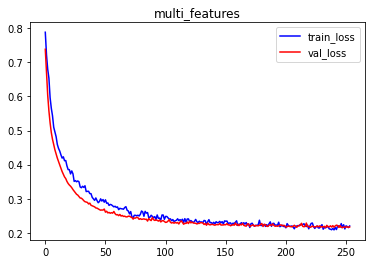

In [22]:
plot_train_history(multi_step_history, 'multi_features')

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

print(r2_score(y_val_multi, multi_step_model.predict(x_val_multi)))

0.7894139621465719


(720, 15) (64, 24) (64, 24)


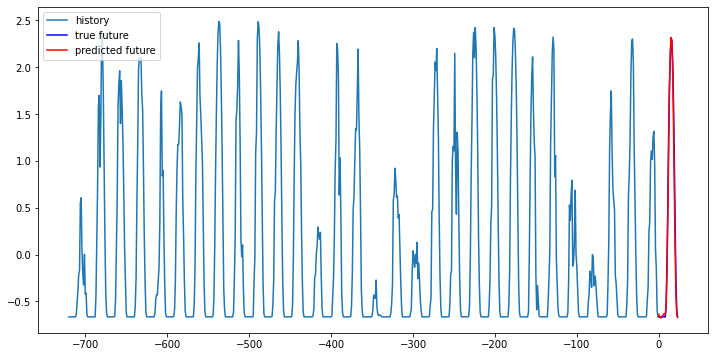

(720, 15) (64, 24) (64, 24)


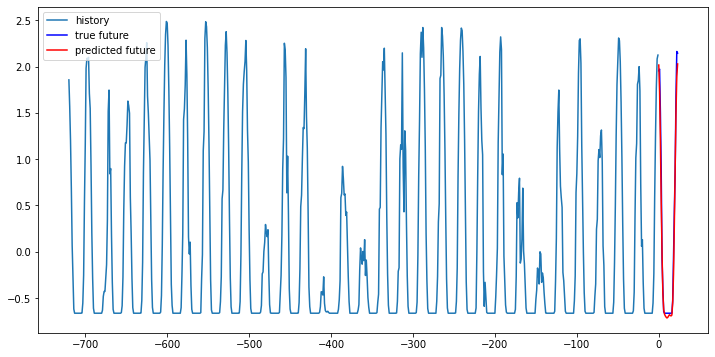

(720, 15) (64, 24) (64, 24)


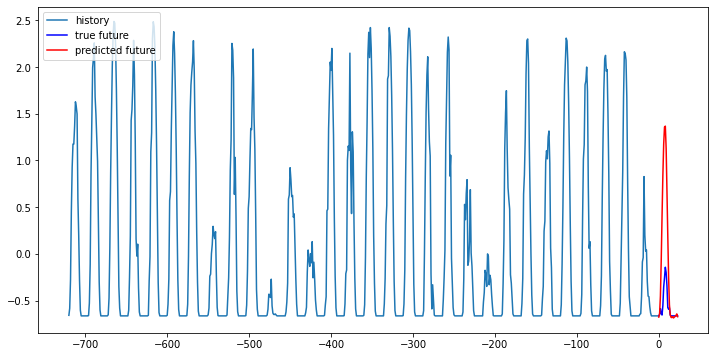

(720, 15) (64, 24) (64, 24)


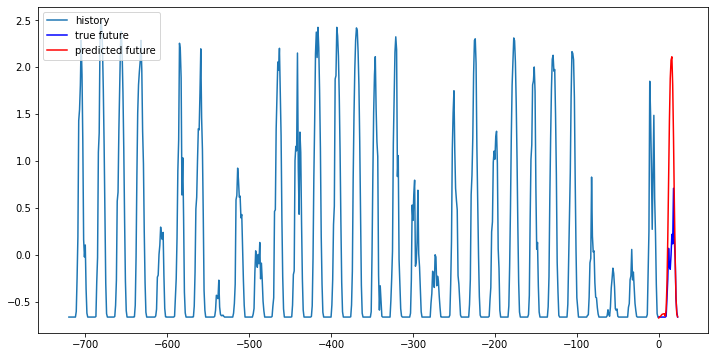

(720, 15) (64, 24) (64, 24)


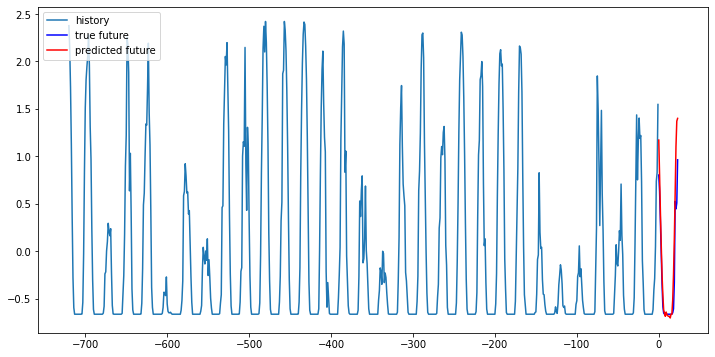

(720, 15) (64, 24) (64, 24)


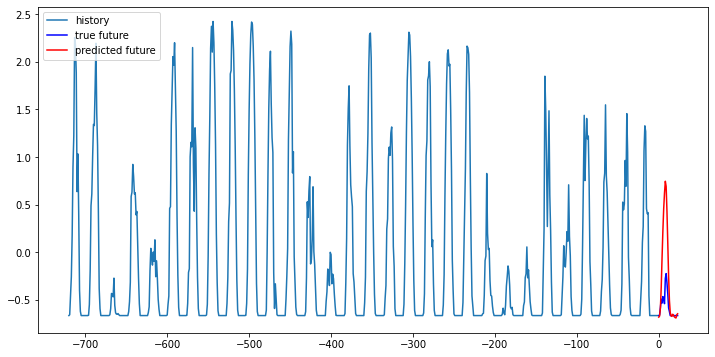

(720, 15) (64, 24) (64, 24)


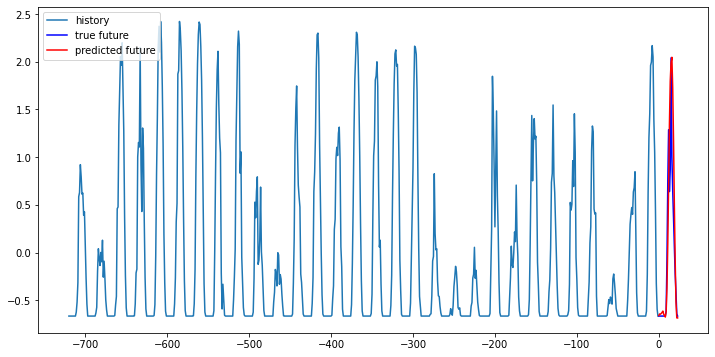

(720, 15) (64, 24) (64, 24)


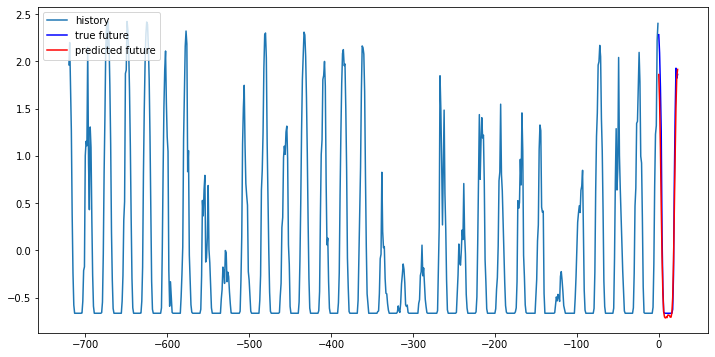

(720, 15) (64, 24) (64, 24)


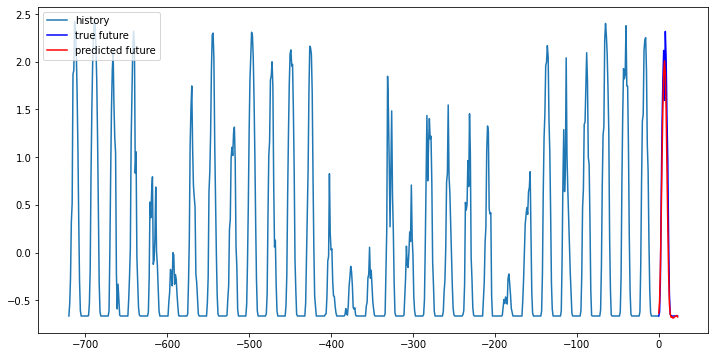

(720, 15) (64, 24) (64, 24)


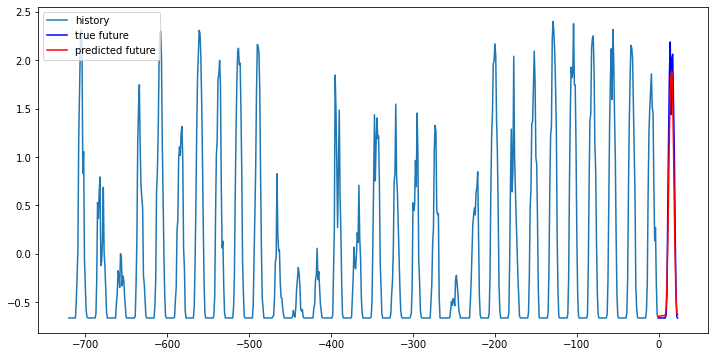

In [24]:
for x, y in val_data_multi.take(10):
    print(x[0].shape, y.shape, multi_step_model.predict(x).shape)
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])